In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing dataset
data = pd.read_csv("wineQualityWhites.csv")

In [3]:
data
print(data.shape)
print(data.head())

(4898, 12)
   fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.

In [4]:
#Sanity Check
data.isnull().sum()


fixed.acidity           0
volatile.acidity        0
citric.acid             0
residual.sugar          0
chlorides               0
free.sulfur.dioxide     0
total.sulfur.dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed.acidity           4898 non-null float64
volatile.acidity        4898 non-null float64
citric.acid             4898 non-null float64
residual.sugar          4898 non-null float64
chlorides               4898 non-null float64
free.sulfur.dioxide     4898 non-null float64
total.sulfur.dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


There are no null values in dataset. It's pretty clean dataset so we can say that data cleaning has done. Also we can see that the dxata has only numerical values. 

   # Exploratory Data Analysis

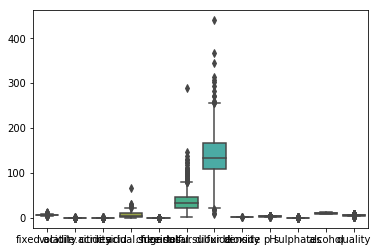

In [6]:
#Checking the distribution
sn.boxplot(data=data, orient = "v")


We plot this boxplot to see if we need to scale. Since one of the features has very large values as compared to other, this implies that we need to scale the data.

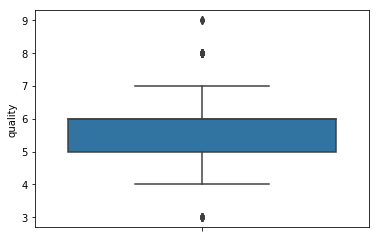

In [7]:
sn.boxplot(data=data, y="quality", orient="pH")

From this plot we can see that there are a lot of medicore wines and less number of bad and really good quality of wines.

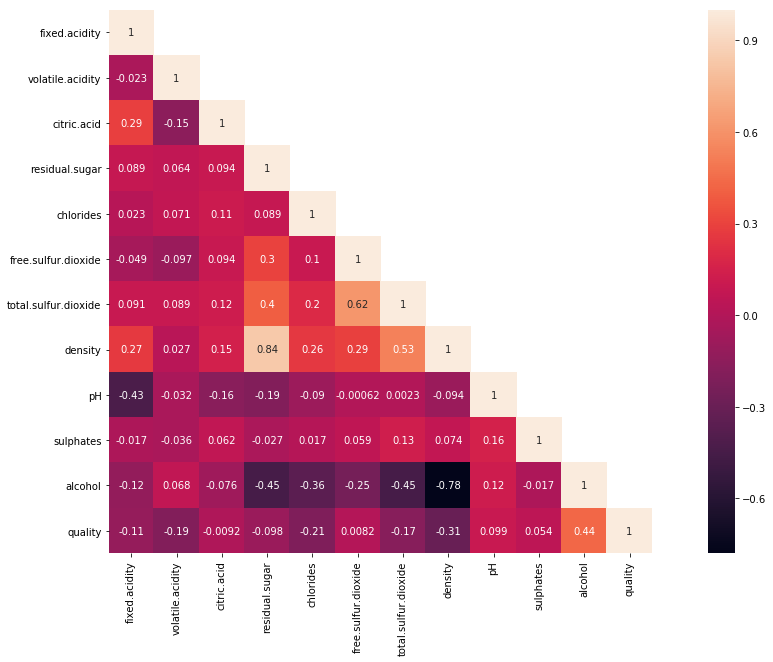

In [8]:
#Correlation Analysis
corrMatt = data.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches (20,10)
sn.heatmap(corrMatt, mask=mask, square = True, annot =True)

From this correlation graph we can see that the features are not very correalted with each other since the values are not very close to -1 or 1. But we can see that not all the features are very correlated with the target value (quality). We can see that citric acid, residual sugar, free sulphur dioxide, pH and sulphates might not have a significant affect on the quality of wine since their correlation value is very close to 1.

**Scaling the data**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

We need to first split the dataset into features and the output result so that we can run our model on the features.


In [10]:
X=data.iloc[:, :-1]
y = data.iloc[:,-1]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0, stratify = y)

In [12]:
#Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross validating some of the coomon regression models to find which algorithm works better

In [13]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [14]:
models = []
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoost', GradientBoostingRegressor()))
models.append(('SVR', SVR()))
names = []

In [15]:
for name,model in models:
    kfold = model_selection.KFold(n_splits=5,random_state=2)
    cv_results = model_selection.cross_val_score(model,X_train,y_train, cv= kfold, scoring = 'neg_mean_absolute_error')
    names.append(name)
    msg  = "%s: %f" % (name, -1*(cv_results).mean())
    print(msg)

DecisionTree: 0.550785
RandomForest: 0.491671
GradientBoost: 0.548333
SVR: 0.524493


# Building the model

In [16]:
model = RandomForestRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [17]:
mean_absolute_error(y_pred,y_test)

0.460734693877551

In [18]:
RandomForestRegressor?

Now, I am going to tune the model further by finding the best value for the paramter n_estimators. This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. One should choose as high value as the processor can handle because this makes your predictions stronger and more stable.

In [19]:
def get_mae_rf(num_est, predictors_train, predictors_val, targ_train, targ_val):

    # fitting model with input max_leaf_nodes
    model = RandomForestRegressor(n_estimators=num_est, random_state=0)

    # fitting the model with training dataset
    model.fit(predictors_train, targ_train)

    # making prediction with the test dataset
    preds_val = model.predict(predictors_val)

    # calculate and return the MAE
    mae = mean_absolute_error(targ_val, preds_val)
    return(mae)

In [20]:
plot_mae = {}
for num_est  in range(2,50):
    new_mae = get_mae_rf(num_est,X_train,X_test,y_train,y_test)
    plot_mae[num_est] = new_mae

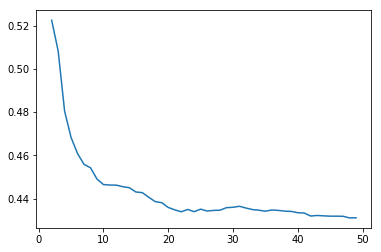

In [21]:
plt.plot(list(plot_mae.keys()),plot_mae.values())
plt.show()

The above graph shows that for all values of n_estimators after 10, the value of MAE is less than the previously obtained value (0.45). So I decided to check the running time for 20, 30 and 40

In [22]:
model = RandomForestRegressor(n_estimators=40)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [23]:
mean_absolute_error(y_pred,y_test)

0.44138775510204087

Since, the dataset is not very large, the processor does not take a lot of time with even the value of 40 which gave the MAE of 0.434, while the value of 20 gave the MAE of 0.444.